
# Food‑101 — Single Image Test (YOLO11n‑cls)

This notebook loads Food‑101 `best.pt`** (from runs named `food101_yolo11n_cls*`) and classifies a single image:

```
/utilities/util_test_images/pasta-carbonara.png
```

It prints **Top‑1** and **Top‑5** predictions and saves an **annotated image** into your models folder.


In [3]:

# --- 1) Configure paths --------------------------------------------------------
IMAGE_PATH = "/home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg"  # ← change if you want to test another image
MODEL_DIR  = "/home/kristoffel/models"
RUN_PREFIX = "food101_yolo11n_cls"  # ← change if your run name differs

import os, glob
assert os.path.isfile(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"
assert os.path.isdir(MODEL_DIR), f"Model dir not found: {MODEL_DIR}"
print("Image:", IMAGE_PATH)
print("Model dir:", MODEL_DIR)
print("Run prefix:", RUN_PREFIX)


Image: /home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg
Model dir: /home/kristoffel/models
Run prefix: food101_yolo11n_cls


In [4]:

# --- 2) Find the newest Food-101 best.pt --------------------------------------
import os, glob

cands = glob.glob(os.path.join(MODEL_DIR, RUN_PREFIX + "*", "weights", "best.pt"))
if not cands:
    raise FileNotFoundError(f"No 'best.pt' found matching {MODEL_DIR}/{RUN_PREFIX}*/weights/best.pt - train first, or set RUN_PREFIX correctly.")
BEST_WEIGHTS = max(cands, key=os.path.getmtime)
print("Using weights:", BEST_WEIGHTS)


Using weights: /home/kristoffel/models/food101_yolo11n_cls/weights/best.pt


In [5]:

# --- 3) Run prediction ---------------------------------------------------------
# If ultralytics is not installed, un-comment the pip line and re-run.
# !pip install -U ultralytics

import torch
from ultralytics import YOLO

device = 0 if torch.cuda.is_available() else "cpu"
print("CUDA available:", torch.cuda.is_available())

model = YOLO(BEST_WEIGHTS)
IMGSZ = 224  # match training size unless you trained otherwise

results = model.predict(
    source=IMAGE_PATH,
    imgsz=IMGSZ,
    device=device,
    save=True,                         # saves annotated image
    project=MODEL_DIR,                 # under your models folder
    name="food101_single_inference"    # subfolder for this test
)
print("Saved annotated image to:", os.path.join(MODEL_DIR, "food101_single_inference"))


CUDA available: True

image 1/1 /home/kristoffel/utilities/util_test_images/pasta-carbonara.jpg: 224x224 spaghetti_bolognese 0.72, spaghetti_carbonara 0.28, ramen 0.00, scallops 0.00, ravioli 0.00, 4.2ms
Speed: 13.9ms preprocess, 4.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /home/kristoffel/models/food101_single_inference
Saved annotated image to: /home/kristoffel/models/food101_single_inference


Top-1: spaghetti_bolognese  (confidence=0.7209)


,rank,class,confidence
0,1,spaghetti_bolognese,0.720887
1,2,spaghetti_carbonara,0.278167
2,3,ramen,0.000460
3,4,scallops,0.000166
4,5,ravioli,0.000116


Saved JSON: /home/kristoffel/models/food101_single_inference/prediction_top5.json


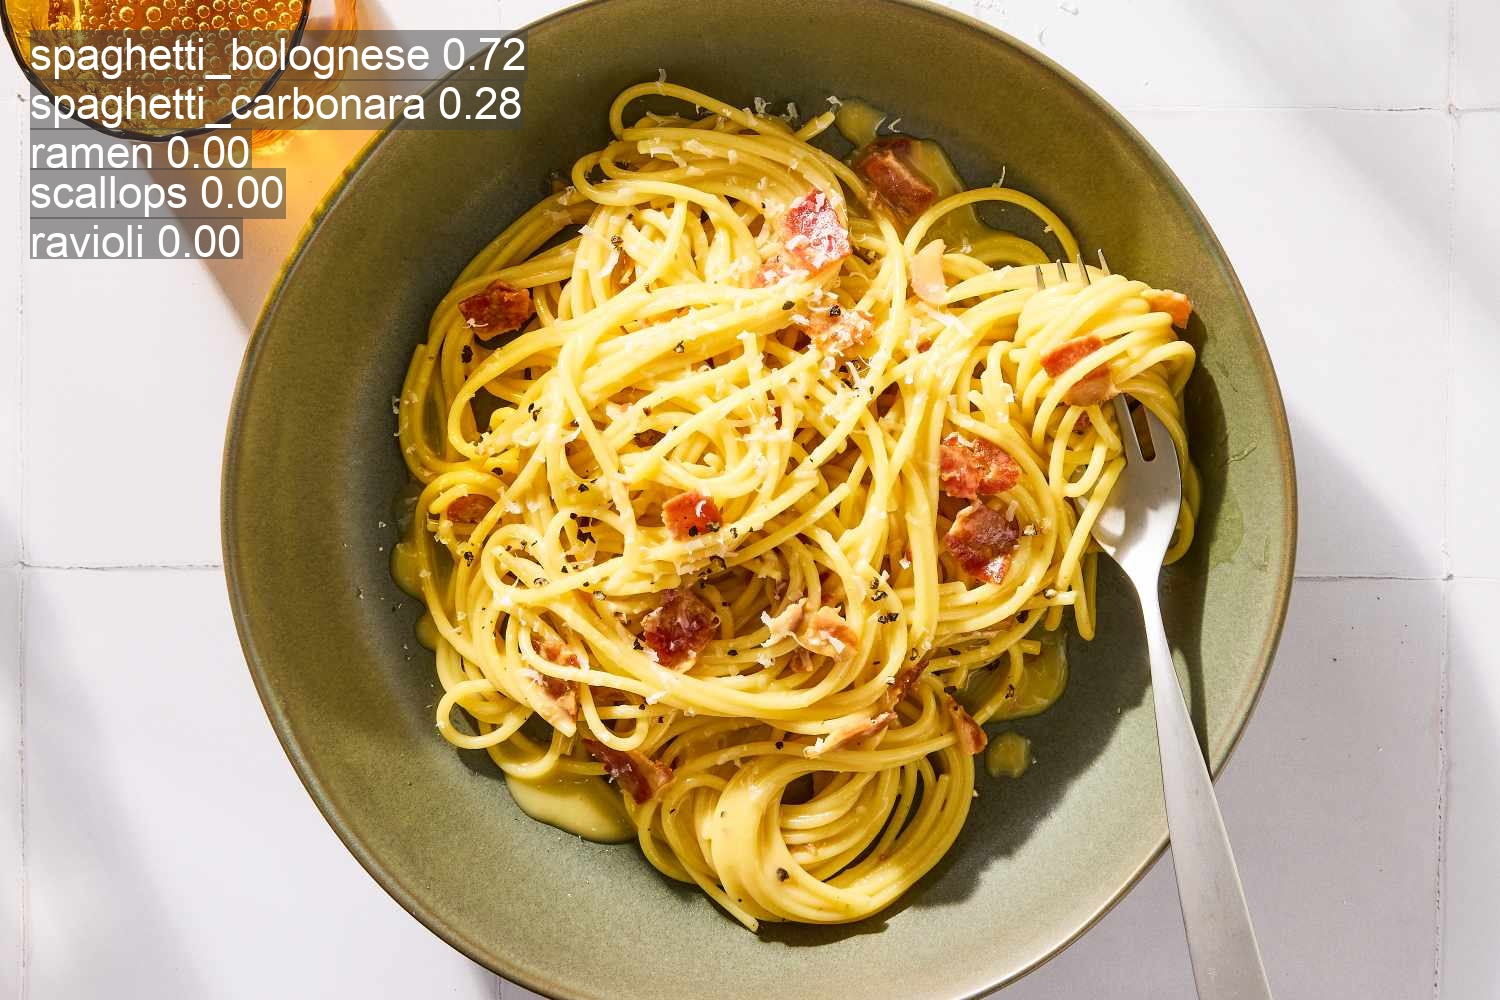

In [6]:

# --- 4) Show Top-1 and Top-5 --------------------------------------------------
import torch as th
import pandas as pd
from IPython.display import display, Image as IPyImage
import os, json

r = results[0]               # single image
names = model.names          # class index -> label mapping
probs = r.probs.data if hasattr(r.probs, "data") else r.probs  # torch.Tensor of shape (101,)

topk = min(5, probs.shape[-1])
conf, idx = th.topk(probs, k=topk)
idx = idx.tolist()
conf = conf.tolist()

top1_name, top1_conf = names[idx[0]], float(conf[0])
print(f"Top-1: {top1_name}  (confidence={top1_conf:.4f})")

df = pd.DataFrame({
    "rank": list(range(1, topk+1)),
    "class": [names[i] for i in idx],
    "confidence": [float(c) for c in conf]
})
display(df)

# Save a small JSON with results next to the annotated image
out_dir = os.path.join(MODEL_DIR, "food101_single_inference")
os.makedirs(out_dir, exist_ok=True)
json_path = os.path.join(out_dir, "prediction_top5.json")
with open(json_path, "w") as f:
    json.dump({"image": IMAGE_PATH, "top1": {"class": top1_name, "confidence": top1_conf},
               "top5": [{"class": names[i], "confidence": float(c)} for i, c in zip(idx, conf)]}, f, indent=2)
print("Saved JSON:", json_path)

# Display annotated image if present
annot_path = os.path.join(out_dir, os.path.basename(IMAGE_PATH))
if os.path.exists(annot_path):
    display(IPyImage(filename=annot_path))
else:
    print("(Annotated image not found; depending on version it may save to a subfolder.)")
